In [1]:
cd("$(homedir())/Documents/enso_project.jl")

In [2]:
using Pkg
Pkg.activate(".")
#Pkg.add("ReservoirComputing")

  Activating project at `C:\Users\lihel\Documents\enso_project.jl`


In [3]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots

In [4]:
# read input data
df_train_data = CSV.read("data/train_sst_34_anomaly_embedded_15.txt", DataFrame; delim=',', ignorerepeated=true)
df_val_data = CSV.read("data/val_sst_34_anomaly_embedded_15.txt", DataFrame; delim=',', ignorerepeated=true)
df_test_data = CSV.read("data/test_sst_34_anomaly_embedded_15.txt", DataFrame; delim=',', ignorerepeated=true)

Row,Column1,Column2,Column3,Column4,Column5
,Float64,Float64,Float64,Float64,Float64
1,-0.33,0.39,-0.93,0.15,0.9
2,-0.26,0.28,-0.7,0.22,0.67
3,0.1,-0.06,-0.67,0.28,0.71
4,0.21,-0.32,-0.73,0.33,0.97
5,0.36,-0.37,-0.49,0.86,0.72
6,0.42,-0.91,-0.11,0.86,0.75
7,0.39,-0.93,0.15,0.9,0.6
8,0.28,-0.7,0.22,0.67,0.42
9,-0.06,-0.67,0.28,0.71,0.15


Now, we generate our first ESN

In [16]:
train_data = Matrix(transpose(Matrix(df_train_data)))

u_train = train_data[:, 1:end-1]    # input data
y_train = train_data[:, 2:end]      # target data

#val_data = Matrix(transpose(Matrix(df_val_data)))

5×344 Matrix{Float64}:
 -0.2   -0.14   0.02   0.49   0.65  …  -0.11  -0.55  -0.92  -1.21  -1.31
  0.86   1.24   1.73   1.68   2.21     -1.44  -1.21  -1.48  -1.19  -0.83
  1.81   1.22   0.68   0.68   0.45     -0.39  -0.31  -0.19  -0.42  -0.67
 -0.44  -0.38  -1.02  -1.29  -1.16     -0.98  -0.99  -0.65  -0.55  -0.44
 -0.16  -0.52  -0.54  -0.69  -1.03     -0.19   0.24   0.27   0.68   0.44

In [15]:
"""
esn = ESN(input_data, # matrix of training data 'num_features x time_steps'
    input_size, # num_features
    res_size;
    reservoir= ,
    input_layer= ,

)
"""
esn = ESN(u_train,
    5,
    300;
    reservoir=rand_sparse(; radius=1.0, sparsity=0.1),
    input_layer=scaled_rand(; scaling=0.1)
    )

esn.res_size

300

In [7]:
"""
    train_esn!(esn, y, ridge_param)

Given an Echo State Network, train it on the target sequence y_target and return the optimised output weights Wₒᵤₜ.
"""
function train_esn!(esn, y_target, ridge_param)
    training_method = StandardRidge(ridge_param)
    return train(esn, y_target, training_method)
end

train_esn!

first try to train an esn

In [8]:
Wₒᵤₜ = train_esn!(esn, y_train, 1e-6)

OutputLayer successfully trained with output size: 5

In [9]:
# evaluate loss on the validation set
steps_to_predict = size(val_data, 2)
prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
loss = sum(abs2, prediction - val_data)

192612.25252583277

plot the prediction the model makes

In [10]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times =  collect(0:steps_to_predict)[1:end-1]

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600))
end

plot_prediction

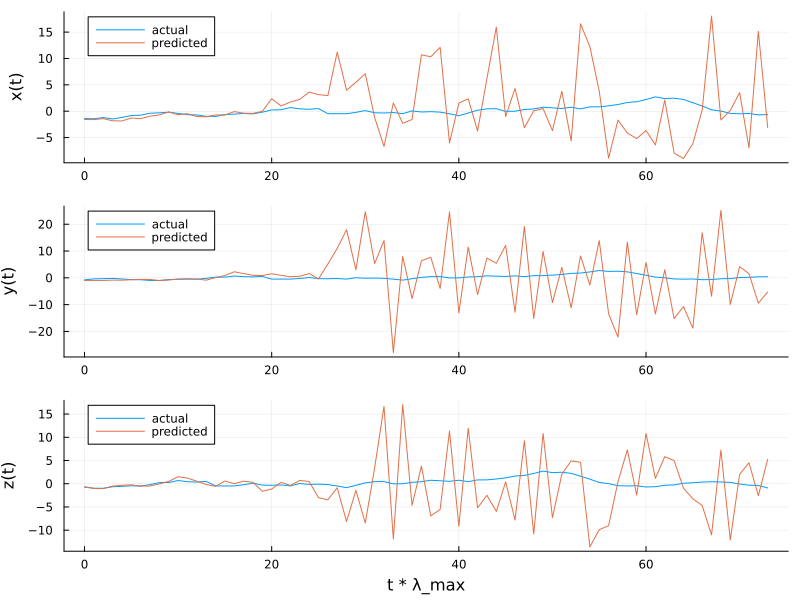

In [11]:
plot_prediction(esn, Wₒᵤₜ , val_data)

In [55]:
function plot_prediction_neu(esn::ESN, Wₒᵤₜ, test_data::Matrix)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times =  collect(0:steps_to_predict)[1:end-1]

    subplots = []
    for i in eachindex(test_data[:,1])
        push!(subplots, plot(times, [test_data[i,:], prediction[i, :]], label=label, ylabel="feature $i"))
    end

    plot(subplots..., layout = (length(subplots), 1), size = (1100, 800))
end

plot_prediction_neu (generic function with 1 method)

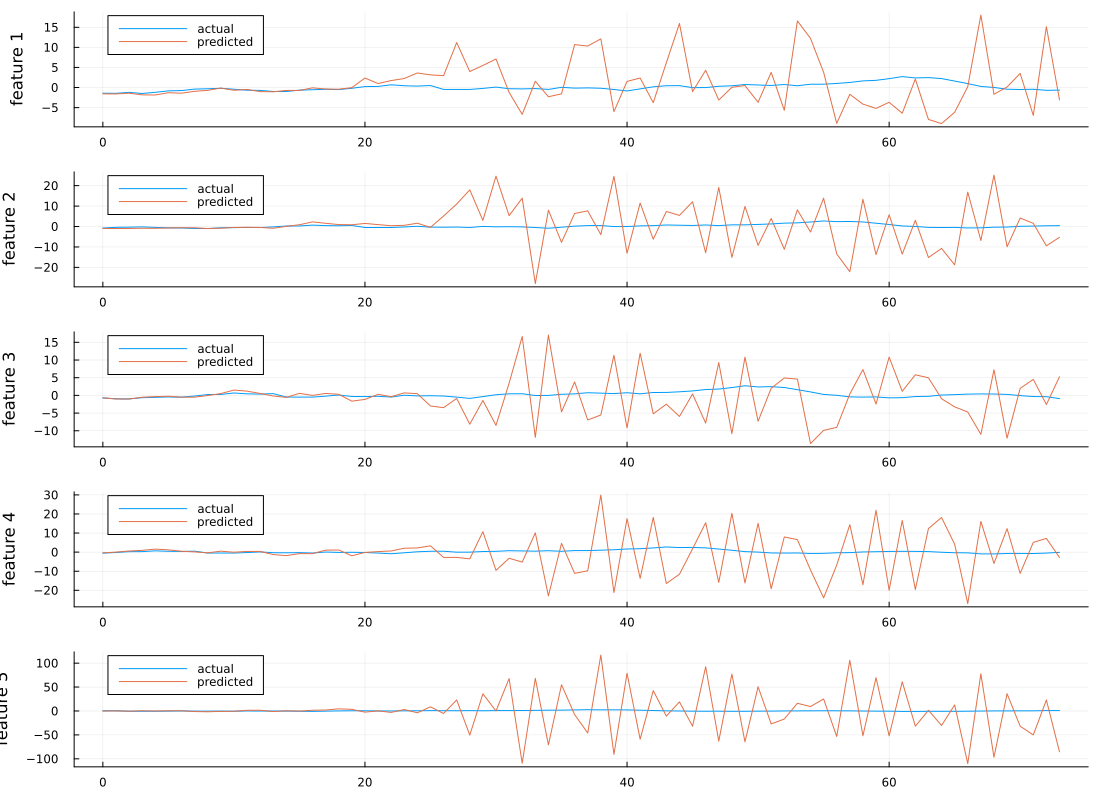

In [56]:
plot_prediction_neu(esn, Wₒᵤₜ , val_data)

In [13]:
struct ESNHyperparams_test
    reservoir_size
    spectral_radius
    sparsity
    input_scale
    ridge_param
end

In [14]:
# Set up the hyperparameter grid-search
param_grid = []

reservoir_sizes = [512, 1024]
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1]
ridge_values = [0.0, 1e-6, 1e-5]

# Take the Cartesian product of the possible values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparams_test(params...))
end

println(param_grid, " hyperparameter combinations.")

Any[ESNHyperparams_test(512, 0.8, 0.03, 0.1, 0.0), ESNHyperparams_test(1024, 0.8, 0.03, 0.1, 0.0), ESNHyperparams_test(512, 1.0, 0.03, 0.1, 0.0), ESNHyperparams_test(1024, 1.0, 0.03, 0.1, 0.0), ESNHyperparams_test(512, 1.2, 0.03, 0.1, 0.0), ESNHyperparams_test(1024, 1.2, 0.03, 0.1, 0.0), ESNHyperparams_test(512, 0.8, 0.05, 0.1, 0.0), ESNHyperparams_test(1024, 0.8, 0.05, 0.1, 0.0), ESNHyperparams_test(512, 1.0, 0.05, 0.1, 0.0), ESNHyperparams_test(1024, 1.0, 0.05, 0.1, 0.0), ESNHyperparams_test(512, 1.2, 0.05, 0.1, 0.0), ESNHyperparams_test(1024, 1.2, 0.05, 0.1, 0.0), ESNHyperparams_test(512, 0.8, 0.03, 0.1, 1.0e-6), ESNHyperparams_test(1024, 0.8, 0.03, 0.1, 1.0e-6), ESNHyperparams_test(512, 1.0, 0.03, 0.1, 1.0e-6), ESNHyperparams_test(1024, 1.0, 0.03, 0.1, 1.0e-6), ESNHyperparams_test(512, 1.2, 0.03, 0.1, 1.0e-6), ESNHyperparams_test(1024, 1.2, 0.03, 0.1, 1.0e-6), ESNHyperparams_test(512, 0.8, 0.05, 0.1, 1.0e-6), ESNHyperparams_test(1024, 0.8, 0.05, 0.1, 1.0e-6), ESNHyperparams_test(51